In [1]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")
from composite_indicators.aggregation import RegressionAggregator

%load_ext autoreload
%autoreload 2

In [2]:
data =load_diabetes()
X = data["data"]
y = data["target"]

In [3]:
preproc_pipeline = Pipeline([
    ("step1", StandardScaler()),
    ("step2", PCA(n_components=2))
])
X_preproc =preproc_pipeline.fit_transform(X)

In [4]:
base_model = SVR(kernel="poly", gamma=3)
base_model.fit(X_preproc, y)
mean_squared_error(y, base_model.predict(X_preproc)), base_model.score(X_preproc, y)

(4525.178254745555, 0.23688598793826754)

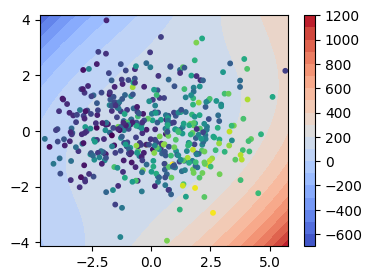

In [5]:
xx, yy = np.meshgrid(
    np.arange(X_preproc[:, 0].min() - 0.2, X_preproc[:, 0].max() + 0.2, 0.1),
    np.arange(X_preproc[:,1].min() - 0.2, X_preproc[:, 1].max() + 0.2, 0.1)
)
X_meshgrid = np.c_[xx.ravel(), yy.ravel()]

pred_mesh = base_model.predict(X_meshgrid)

plt.figure(figsize=(4, 3))
plt.contourf(xx, yy, pred_mesh.reshape(xx.shape), 20, cmap=plt.cm.coolwarm) # , cmap='RdGy'
plt.colorbar()

plt.scatter(*X_preproc.T, c=y, s=10)

In [6]:
local_model = KMeans(5, n_init=10)
global_model = KMeans(9)
agg_model = RegressionAggregator(global_model=global_model, global_alpha=3, local_model=local_model)
X_agg, y_agg = agg_model.fit_transform(X_preproc, y)

agg_model = SVR(kernel="poly", gamma=3)
agg_model.fit(X_agg, y_agg)
mean_squared_error(y, agg_model.predict(X_preproc)), agg_model.score(X_preproc, y)

/home/kyamkovyi/.cache/pypoetry/virtualenvs/composite-indicators-6SsfGY5N-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(6473.239683734405, -0.09162990450406938)

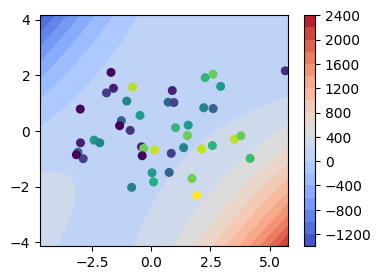

In [7]:
pred_mesh = agg_model.predict(X_meshgrid)

plt.figure(figsize=(4, 3))
plt.contourf(xx, yy, pred_mesh.reshape(xx.shape), 20, cmap=plt.cm.coolwarm) # , cmap='RdGy'
plt.colorbar()

plt.scatter(*X_agg.T, c=y_agg, s=30)